# Fitting the exponential decay following a step increase in voltage across electronic model maxwell system

In [1]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
plt.style.use('ggplot')

I have put the data in the Github folder so the container can access it. I specify teh path here and then import teh csv files obtained from teh oscilloscope. Each file contains two columns, the zeroth for time, and the first for voltage.

The skiprows is required because one of the comments in teh csv file at the top begins with ',#' not just '#' making it fail at importing.

In [19]:
general_path = 'Oscilloscope data CRI electronics analogy/'
specific_path = 'AWG 7V step/normal/'
#specific_path = 'Analogue voltage source 7V step function/normal values/'
path = general_path + specific_path

channel_1_data = np.loadtxt(path+'Channel 1 total voltage.csv', delimiter=',', skiprows=3)
channel_2_data = np.loadtxt(path+'Channel 2 voltage resistor arm 1.csv', delimiter=',', skiprows=3)

Here I analyse the step region to discover it is not a perfect step up.

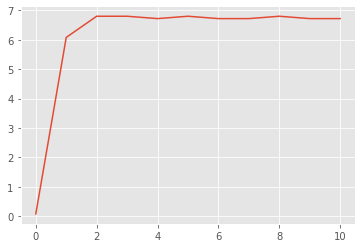

In [20]:
step_range = channel_1_data[599:610, 1]
plt.plot(step_range)

As a result the value I choose the threshold as the 'on' region has some arbitrary nature to it and will cause imperfect fitting.

Regardless, the logic of the next block is that `bool_keeps` is an array where `False` is present for every element that was below the threshold, and `True` is present for data above it. This is then used as on an element by element basis to include or not include the rows of `channel_1_data` etc.

`time_scaffold` is needed as time needs to start from 0 for the fitting to work, so this corrects for that, otherwise a much greater decay will make sense for larger time points.

In [21]:
bool_keeps = channel_1_data[:, 1] > 6.5

voltage = channel_1_data[bool_keeps, 1]
voltage_r1 = channel_2_data[bool_keeps, 1]

time_scaffold = channel_1_data[bool_keeps, 0]
time = time_scaffold - time_scaffold[0]

Here, I recover teh current from the voltages measured.

The below has a big measurement oversight is that to get current from these voltages, I need to assume or already know all of my resistances.

In [22]:
r_0 = 1.995e3
r_1 = 1.999e3

current_0 = voltage/r_0
current_1 = voltage_r1/r_1
current = current_0 + current_1

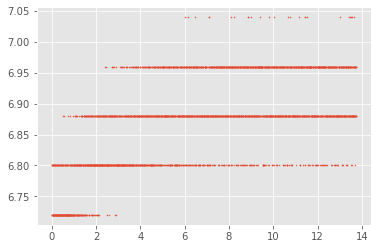

In [23]:
plt.plot(time, voltage, label='voltage', linestyle='None', marker='.', markersize=1)

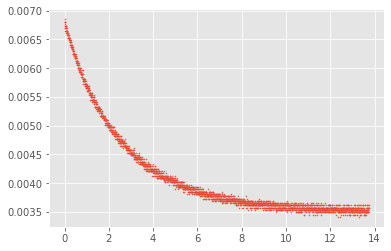

In [24]:
plt.plot(time, current, label='current', linestyle='None', marker='.', markersize=1)

## least_squares method

Here, the parameters to optimise are stored as a 1d array, called `x`.

The crux of this method is to define a function that calculates the error between a prediction from an equation and the actual data, here `resid_lambda`.

`resid_lambda` only has one parameter as the arrays for time and current are prepackaged into the lambda function, as is v_step.

In [25]:
v_step = np.mean(voltage)
pred_lambda = lambda x: v_step*(1/x[0] + np.exp(-time/x[2])/x[1])
resid_lambda = lambda x: pred_lambda(x) - current

A guess on the parameters to find must be made, here I just guess ones.

A dictionary, mostly of uninteresting stuff, is returned. The best fit parameters are identified by keyword `'x'`.

In [26]:
x = np.ones(3)
result_dict = opt.least_squares(resid_lambda, x)
result_dict

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in multiply
  


 active_mask: array([0., 0., 0.])
        cost: 2.9710125063178375e-06
         fun: array([-1.26108788e-04, -9.09860424e-05, -9.57955889e-05, ...,
       -3.51832494e-05,  4.48309561e-05, -7.53350895e-05])
        grad: array([-5.06126266e-12,  1.13586334e-12, -8.05048353e-09])
         jac: array([[-1.79847192e-06, -1.49625246e-06,  0.00000000e+00],
       [-1.79847192e-06, -1.49396799e-06,  1.86930089e-06],
       [-1.79847192e-06, -1.49168701e-06,  3.73286521e-06],
       ...,
       [-1.79847194e-06, -7.88703713e-09,  3.38783021e-05],
       [-1.79847194e-06, -7.87502207e-09,  3.38364118e-05],
       [-1.79847192e-06, -7.86296628e-09,  3.37945993e-05]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 56
        njev: 45
  optimality: 8.050483527536382e-09
      status: 1
     success: True
           x: array([1955.32142193, 2143.71746793,    2.61786439])

I plot below the fit and the target data. I also plot, based off the measured or labelled properties of the parts used, the exponential predicted.

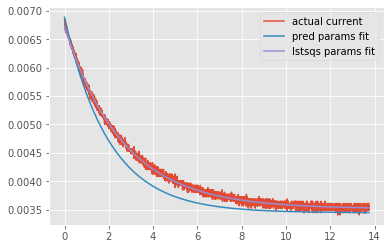

In [27]:
new_x = result_dict['x']
c_1 = 1e-3
tau_1 = r_1*c_1
correct_x = np.array([r_0, r_1, tau_1])
plt.plot(time, current, label='actual current')
plt.plot(time, pred_lambda(correct_x), label='pred params fit')
plt.plot(time, pred_lambda(new_x), label='lstsqs params fit')
plt.legend()

## curve_fit method

This alternative method actually is a wrapper for the above but arguably frames the problem in a more readbale way.

Here, the parameters to optimise are not stored in an array but explicitely different additional arguments (beyond the independant variable, time) for the prediction function.

The lambda function used is very similar to `pred_lambda` above but only prepackages v_step and takes the parameters to optimise as individual parameters as stated.

In [28]:
v_step = np.mean(voltage)
pred_lambda_2 = lambda time, r0, r1, tau1: v_step*(1/r0 + np.exp(-time/tau1)/r1)

The function below then does the remaining prep work from above when we used least_squares and then runs least squares, all based on providing `curve_fit` with the time and current data only here.

It also returns less garbage, with the predicted parameters being the first item in the returned tuple.

In [29]:
result_tuple = opt.curve_fit(pred_lambda_2, time, current)
result_tuple

(array([1955.33741394, 2143.73973686,    2.61801618]),
 array([[ 5.45705234e-01, -7.03555921e-02,  3.01867244e-03],
        [-7.03555921e-02,  4.72574916e+00,  5.37976790e-03],
        [ 3.01867244e-03,  5.37976790e-03,  3.08145242e-05]]))

curve_fit still returns the fit parameters in the same format as was more natural in the least_squares method (an array), so pulling out the parameters again to plot using the lambda function here defined is a little awkward.

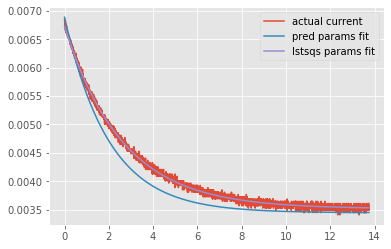

In [30]:
new_x_2 = result_tuple[0]
plt.plot(time, current, label='actual current')
plt.plot(time, pred_lambda_2(time, r_0, r_1, tau_1), label='pred params fit')
plt.plot(time, pred_lambda_2(time, new_x_2[0], new_x_2[1], new_x_2[2]), label='lstsqs params fit')
plt.legend()

Extra note is that the resistances determined are likely to not be correct for a number of reasons:

- The analysis assumes an ideal system where all the resistance and capacitance in the circuit is found in three components. In reality, the jumpers, breadboard, probes, all have RC properties, confounding results.

- The 'step' was not a true step and is not perfectly stable once it reaches its target voltage.

- the values of resistance used to go from voltage to current are not precisely known as the multimeter fluctuated during measurement and additional wires were used in measurement.